## Credit Card Fraud Detection using XGBoost

## Initial Data Processing

In [ ]:
#%%bash
#wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
#unzip creditcardfraud.zip

In [1]:
#import all the needed libraries.
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#pre-requisites: create S3 bucket, upload files, set IAM roles for Sagemaker to access to S3 bucket

role = get_execution_role()
bucket ='sagemaker-ml-lab-tx'
sub_folder = 'datasets'
data_key = 'creditcard.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
print(data_location)

In [ ]:
#Read CSV from S3
#df = pd.read_csv(data_location, low_memory=False)
#df.head()

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('creditcard.csv', delimiter=',')

In [3]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [4]:
print(data.columns)
data[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()
data.head(10)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
5  0.260314 -0.568671  ... -0.208254 -0.559825 -0.026398 -0.371427 -0.232794   
6  0.081213  0.464960  ... -0.167716 -0.270710 -0.154104 -0.780055  0.750137   
7 -3.807864  0.615375  ...  1.943465 -1.015455  0.057504 -0.649709 -0.415267   
8  0.851084 -0.392048  ... -0.073425 -0.268092 -0.204233  1.011592  0.373205   
9  0.069539 -0.736727  ... -0.246914 -0.633753 -0.120794 -0.385050 -0.069733   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  
5  0.105915  0.253844  0.081080    3.67      0  
6 -0.257237  0.034507  0.005168    4.99      0  
7 -0.051634 -1.206921 -1.085339   40.80      0  
8 -0.384157  0.011747  0.142404   93.20      0  
9  0.094199  0.246219  0.083076    3.68      0  

[10 rows x 31 columns]

In [5]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


In [6]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

## SageMaker XGB

In [7]:
model_data = data
model_data.head()
model_data = pd.concat([model_data['Class'], model_data.drop(['Class'], axis=1)], axis=1)
model_data.head()


Class  Time        V1        V2        V3        V4        V5        V6  \
0      0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1      0   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2      0   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3      0   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4      0   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8  ...       V20       V21       V22       V23       V24  \
0  0.239599  0.098698  ...  0.251412 -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676  ...  0.524980  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436  ... -0.208038 -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  
0  0.128539 -0.189115  0.133558 -0.021053  149.62  
1  0.167170  0.125895 -0.008983  0.014724    2.69  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66  
3  0.647376 -0.221929  0.062723  0.061458  123.50  
4 -0.206010  0.502292  0.219422  0.215153   69.99  

[5 rows x 31 columns]

In [10]:
#Convert NumPy n-dimensional arrays into a the Record-IO format

import boto3
import os
import sagemaker


session = sagemaker.Session()

bucket = session.default_bucket()
sagemaker_iam_role = sagemaker.get_execution_role()
bucket ='sagemaker-ml-lab-tx'
prefix = 'fraud-xgboost'

train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)


boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')) \
                                .upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')) \
                                .upload_file('validation.csv')
s3_train_data = 's3://{}/{}/train/train.csv'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket, prefix)
print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-ml-lab-tx/fraud-xgboost/train/train.csv
Uploaded training data location: s3://sagemaker-ml-lab-tx/fraud-xgboost/validation/validation.csv
Training artifacts will be uploaded to: s3://sagemaker-ml-lab-tx/fraud-xgboost/output


---
## Train



In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost','0.90-1')

In [12]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [13]:
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [14]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2020-04-06 02:07:41 Starting - Starting the training job...
2020-04-06 02:07:43 Starting - Launching requested ML instances.........
2020-04-06 02:09:14 Starting - Preparing the instances for training...
2020-04-06 02:10:01 Downloading - Downloading input data...
2020-04-06 02:10:24 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[02:10:52] 199364x30 matrix with 5980920 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter

Training seconds: 94
Billable seconds: 94


### Host XGBoost Model

In [15]:
#deploy the estimator to and endpoint.
xgb.name = 'deployed-xgboost-fraud-prediction'
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge',
                          endpoint_name='deployed-xgboost-fraud-prediction')

---------------!

### Evaluate



In [16]:
from sagemaker.predictor import csv_serializer 

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [18]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.values[:, 1:])

In [19]:
test_nonfrauds, test_frauds = test_data.groupby('Class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data:', 100.*test_frauds/(test_frauds + test_nonfrauds))

Number of frauds:  54
Number of non-frauds:  28427
Percentage of fradulent data: 0.1896000842667041


In [20]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions    0.0  1.0
actual                 
0            28426    1
1               12   42

In [21]:
#precision: tp / (tp + fp)
#recall: tp / (tp + fn)
from sklearn.metrics import precision_recall_fscore_support
results = precision_recall_fscore_support(test_data.iloc[:, 0],
                                         np.round(predictions))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))

precision:  0.98
recall:  0.78


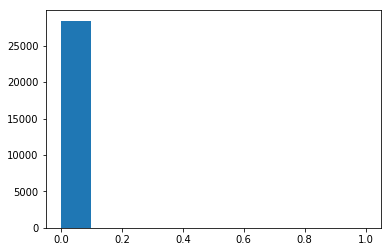

In [22]:
plt.hist(predictions)
plt.show()

By varying the cutoff threshold, we can trade false positives for false negatives. 

In [23]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.04, 1, 0))

col_0      0   1
Class           
0      28413  14
1          8  46

In [24]:
results = precision_recall_fscore_support(test_data.iloc[:, 0],
                                         np.where(predictions > 0.04, 1, 0))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))

precision:  0.77
recall:  0.85


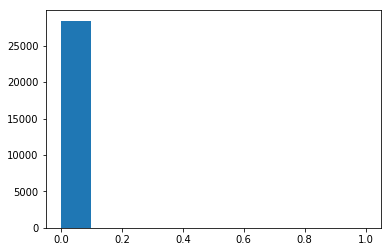

In [25]:
plt.hist(predictions)
plt.show()

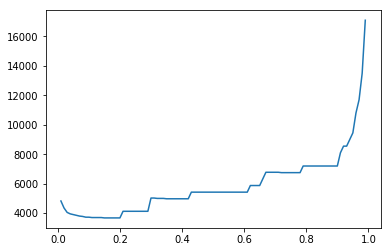

Cost is minimized near a cutoff of: 0.15000000000000002


In [26]:
TN_cost = 0
TP_cost = 0
FP_cost = 0.05*500 #$cost of losing an annoyed customer (assuming 5% defection and $500 sign-on bonus)
FN_cost = 450 # $cost of of letting a fradulent transaction slip through

cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[TN_cost, FP_cost], [FN_cost, TP_cost]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)])

## Clean up


In [27]:
#xgb_predictor.delete_endpoint()